<a href="https://colab.research.google.com/github/dmika1234/dl_uwr/blob/develop/Assignments/Assignment2/colab_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
import os
import time
from IPython.display import clear_output
from tqdm.auto import tqdm
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.datasets
from torch import nn

In [5]:
# Colab
# %load_ext autoreload
# %autoreload
import httpimport
with httpimport.github_repo(
     "dmika1234", "dl_uwr", "develop"
):
     from Assignments.Assignment2.funs import compute_error_rate, plot_history, create_mnist_loaders, SGD, Model, exp_schedule, div_schedule, div_schedule2, check_if_best, Dropout, train_model, BatchNorm

In [3]:
# On GPU enabled devices set device='cuda' else set device='cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data download

In [ ]:
batch_size = 128
data_path = "./data"
mnist_loaders = create_mnist_loaders(batch_size=batch_size, data_path=data_path, download=True)

### Problem 3

In [7]:
alpha = 0.25
epsilon = 0.9
decay=0.0
max_num_epochs = 30
hidden_neurons = 800
gain = 0.1
lr_schedule = (partial(div_schedule2, threshold=10), "epochs")

torch.manual_seed(2137)
model = Model(nn.Linear(28 * 28, hidden_neurons),
              nn.ReLU(),
              nn.Linear(hidden_neurons, hidden_neurons),
              nn.ReLU(),
              nn.Linear(hidden_neurons, 10))
model.init_params_xavier(gain=gain)

----------------------------------------------------------
After epoch 20 | valid err rate:  1.50% | doing  20 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 13)

-------------------------------------------
Test error rate: 1.670%, training took 24s.
-------------------------------------------


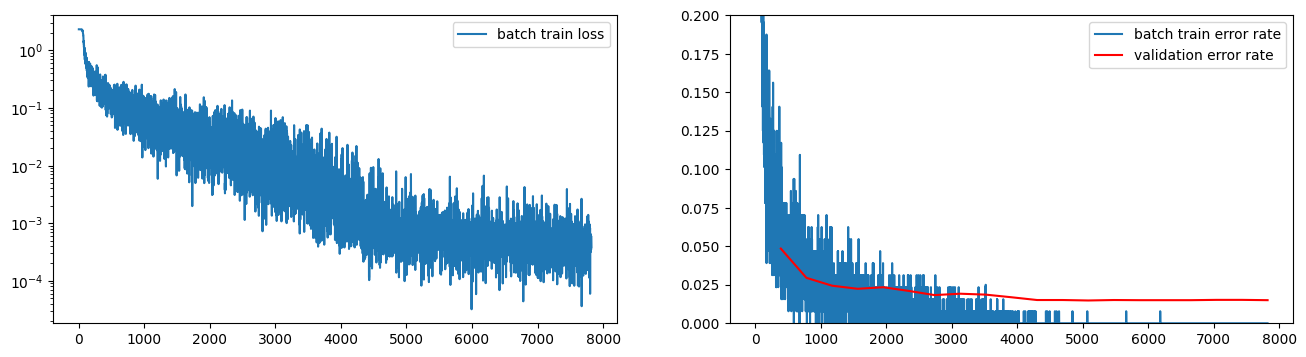

In [8]:
train_model(model, mnist_loaders, alpha, epsilon, lr_schedule, decay, max_num_epochs, train_transform=None, device=device)

### Conv2d and Maxpool

In [11]:
alpha = 0.25
epsilon = 0.9
decay=0.0
max_num_epochs = 30
hidden_neurons = 800
gain = 0.1
lr_schedule = (partial(div_schedule2, threshold=10), "epochs")

torch.manual_seed(2023)
model = Model(nn.Unflatten(-1, (1, 28, 28)),
              nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),
              nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),
              nn.Flatten(),
              nn.Linear(64*7*7, 64*7*7),
              nn.ReLU(),
              nn.Linear(64*7*7, 10))
model.init_params_xavier(gain=gain)

----------------------------------------------------------
After epoch 30 | valid err rate:  0.82% | doing  31 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 20)

--------------------------------------------
Test error rate: 0.730%, training took 114s.
--------------------------------------------


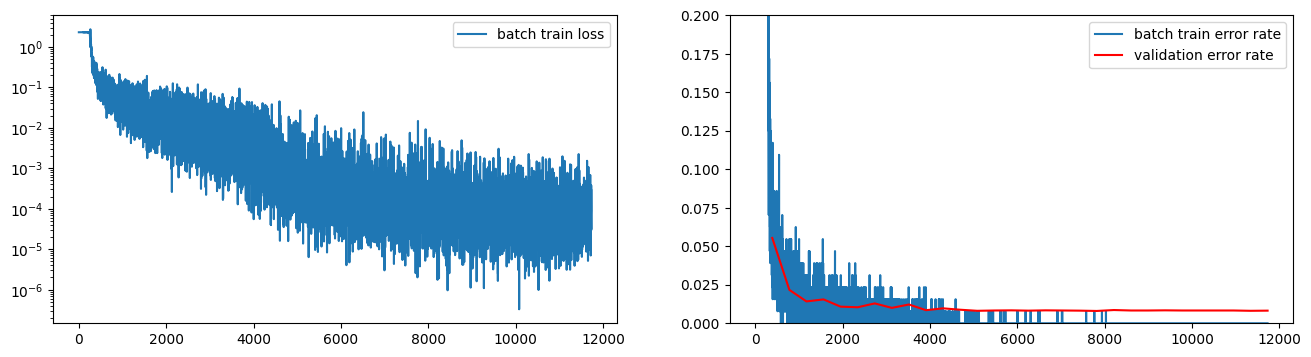

In [12]:
train_model(model, mnist_loaders, alpha, epsilon, lr_schedule, decay, max_num_epochs, train_transform=None, device=device)

### Droput

In [13]:
alpha = 0.25
epsilon = 0.9
decay=0.0
max_num_epochs = 30
hidden_neurons = 800
gain = 0.1
lr_schedule = (partial(div_schedule2, threshold=10), "epochs")

torch.manual_seed(2023)
model = Model(nn.Linear(28 * 28, hidden_neurons),
              nn.ReLU(),
              nn.Linear(hidden_neurons, hidden_neurons),
              Dropout(0.66),
              nn.ReLU(),
              nn.Linear(hidden_neurons, 10))
model.init_params_xavier(gain=gain)

----------------------------------------------------------
After epoch 23 | valid err rate:  1.50% | doing  23 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 15)

-------------------------------------------
Test error rate: 1.450%, training took 33s.
-------------------------------------------


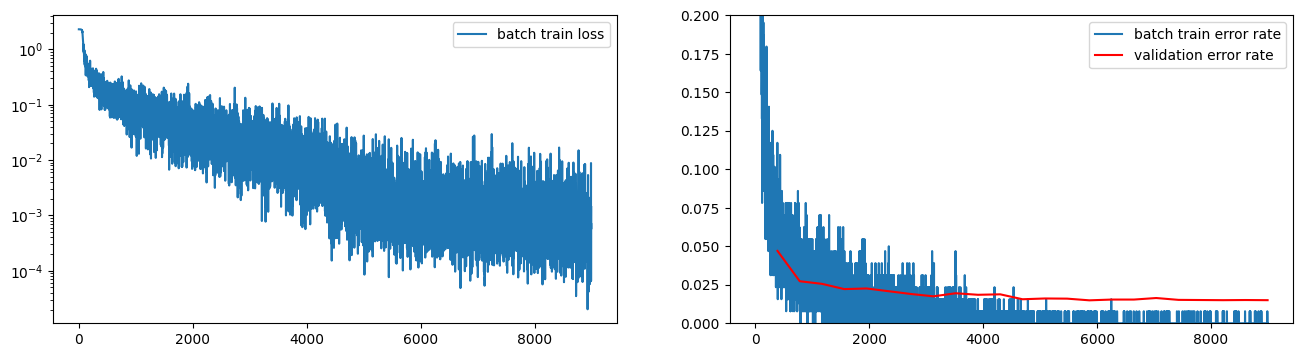

In [14]:
train_model(model, mnist_loaders, alpha, epsilon, lr_schedule, decay, max_num_epochs, train_transform=None, device=device)

### Data Augmentation

In [20]:
alpha = 0.25
epsilon = 0.9
decay=0.0
max_num_epochs = 30
hidden_neurons = 800
gain = 0.1
lr_schedule = (partial(div_schedule2, threshold=10), "epochs")

torch.manual_seed(2023)
model = Model(nn.Linear(28 * 28, hidden_neurons),
              nn.ReLU(),
              nn.Linear(hidden_neurons, hidden_neurons),
              nn.ReLU(),
              nn.Linear(hidden_neurons, 10))
model.init_params_xavier(gain=gain)

transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

----------------------------------------------------------
After epoch 30 | valid err rate:  1.05% | doing  40 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 26)

-------------------------------------------
Test error rate: 1.000%, training took 40s.
-------------------------------------------


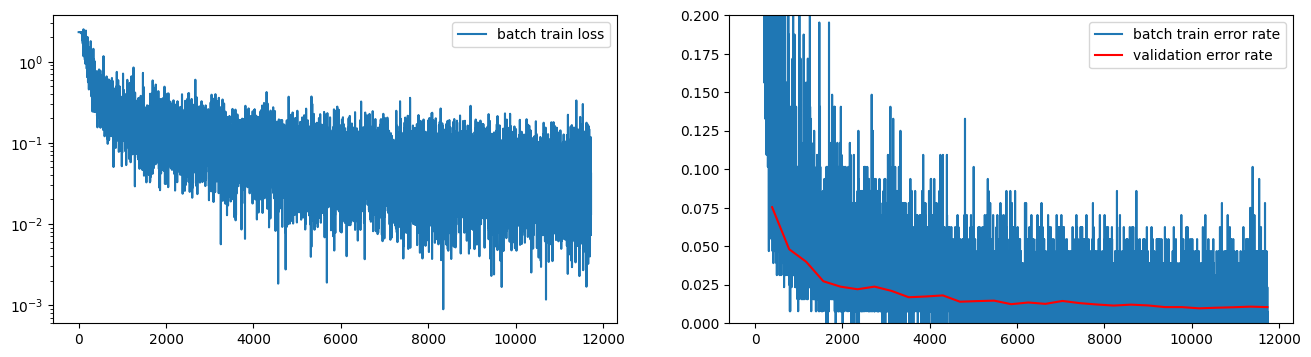

In [21]:
train_model(model, mnist_loaders, alpha, epsilon, lr_schedule, decay, max_num_epochs, train_transform=transforms_train, device=device)

### Batch normalization

In [23]:
alpha = 0.25
epsilon = 0.9
decay=0.0
max_num_epochs = 30
hidden_neurons = 800
gain = 0.1
lr_schedule = (partial(div_schedule2, threshold=10), "epochs")

torch.manual_seed(2137)
model = Model(nn.Linear(28 * 28, hidden_neurons),
              nn.ReLU(),
              nn.Linear(hidden_neurons, hidden_neurons),
              BatchNorm(hidden_neurons),
              nn.ReLU(),
              nn.Linear(hidden_neurons, 10))
model.init_params_xavier(gain=gain)

----------------------------------------------------------
After epoch 30 | valid err rate:  1.39% | doing  31 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 20)

-------------------------------------------
Test error rate: 1.420%, training took 35s.
-------------------------------------------


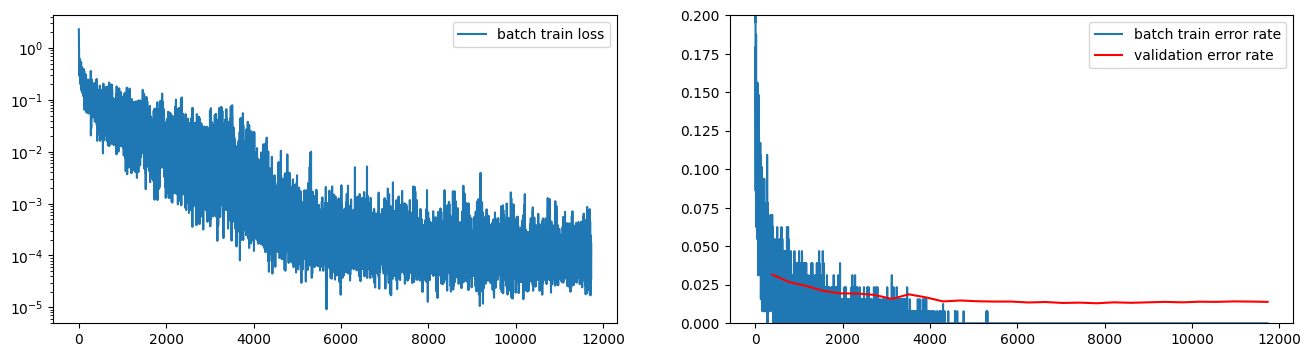

In [24]:
train_model(model, mnist_loaders, alpha, epsilon, lr_schedule, decay, max_num_epochs, train_transform=None, device=device)

### Norm Constraints